## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms, utils
from models import Net

net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (dr

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
from data_load import LandmarkDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop

# testing that you've defined a transform

data_transform = transforms.Compose([Rescale(250),
                                    RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])
assert(data_transform is not None), 'Define a data_transform'


In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='defaultData/training_frames_keypoints.csv',
                                             root_dir='defaultData/training/',
                                             transform=data_transform)

#landmark_train_dataset = LandmarkDataset(csv_file='data/train.csv', img_dir='data/images/train/', transform=data_transform)

print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='defaultData/test_frames_keypoints.csv',
                                             root_dir='defaultData/test/',
                                             transform=data_transform)
#landmark_test_dataset = LandmarkDataset(csv_file='data/test.csv', img_dir='data/images/test/', transform=data_transform)


In [7]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        images = images.to(device)
        key_pts = key_pts.to(device)
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

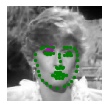

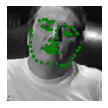

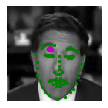

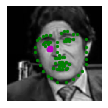

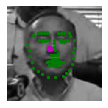

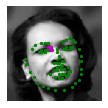

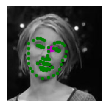

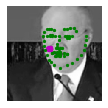

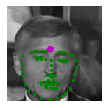

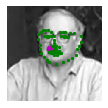

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.detach().cpu().clone().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.detach().cpu().clone().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        ground_truth_pts = ground_truth_pts.to(device)
        ground_truth_pts= ground_truth_pts.detach().cpu().clone().numpy()
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)





## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
def NME(output_pts, key_pts):
    
    d = np.sqrt(224*224)
    NME = torch.sum(torch.sqrt(torch.sum((key_pts-output_pts)**2, dim = 1))/d)/68
    
    return NME

def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            images = images.to(device)
            key_pts = key_pts.to(device)

            # forward pass to get outputs
            output_pts = net(images)
            #output_pts = output_pts.type(torch.FloatTensor)
            #print(output_pts.type)
            #print(key_pts.type)
            # calculate the loss between predicted and target keypoints
            #print(output_pts.shape)
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [14]:
print(torch.cuda.current_device())

0


In [15]:
# train your network
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
# with active_session():
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.003931366756558418
Epoch: 1, Batch: 20, Avg. Loss: 0.002899891138076782
Epoch: 1, Batch: 30, Avg. Loss: 0.0020242412388324737
Epoch: 1, Batch: 40, Avg. Loss: 0.0022005058228969573
Epoch: 1, Batch: 50, Avg. Loss: 0.002076499745249748
Epoch: 1, Batch: 60, Avg. Loss: 0.0019028159454464913
Epoch: 1, Batch: 70, Avg. Loss: 0.001939332939684391
Epoch: 1, Batch: 80, Avg. Loss: 0.001888308510184288
Epoch: 1, Batch: 90, Avg. Loss: 0.002710432976484299
Epoch: 1, Batch: 100, Avg. Loss: 0.002733867406845093
Epoch: 1, Batch: 110, Avg. Loss: 0.002016974106431007
Epoch: 1, Batch: 120, Avg. Loss: 0.0017796305194497108
Epoch: 1, Batch: 130, Avg. Loss: 0.002951144441962242
Epoch: 1, Batch: 140, Avg. Loss: 0.0021044444888830183
Epoch: 1, Batch: 150, Avg. Loss: 0.002124219864606857
Epoch: 1, Batch: 160, Avg. Loss: 0.0022298681288957594
Epoch: 1, Batch: 170, Avg. Loss: 0.0019415406882762908
Epoch: 1, Batch: 180, Avg. Loss: 0.0018330554366111755
Epoch: 1, Batch: 190, Avg. Lo

Epoch: 5, Batch: 160, Avg. Loss: 0.0015126591697335243
Epoch: 5, Batch: 170, Avg. Loss: 0.0012368815168738365
Epoch: 5, Batch: 180, Avg. Loss: 0.0021886511743068695
Epoch: 5, Batch: 190, Avg. Loss: 0.0018508100360631944
Epoch: 5, Batch: 200, Avg. Loss: 0.002389962501823902
Epoch: 5, Batch: 210, Avg. Loss: 0.001723737522959709
Epoch: 5, Batch: 220, Avg. Loss: 0.0017673600018024444
Epoch: 5, Batch: 230, Avg. Loss: 0.0017847799956798554
Epoch: 5, Batch: 240, Avg. Loss: 0.001689004510641098
Epoch: 5, Batch: 250, Avg. Loss: 0.0017032494768500328
Epoch: 5, Batch: 260, Avg. Loss: 0.0019441560879349708
Epoch: 5, Batch: 270, Avg. Loss: 0.0018506584838032722
Epoch: 5, Batch: 280, Avg. Loss: 0.001640401914715767
Epoch: 5, Batch: 290, Avg. Loss: 0.0013654335215687752
Epoch: 5, Batch: 300, Avg. Loss: 0.001685572326183319
Epoch: 5, Batch: 310, Avg. Loss: 0.0014237595573067664
Epoch: 5, Batch: 320, Avg. Loss: 0.001600305013358593
Epoch: 5, Batch: 330, Avg. Loss: 0.0017517309188842774
Epoch: 5, Batch:

Epoch: 9, Batch: 310, Avg. Loss: 0.0015214652121067047
Epoch: 9, Batch: 320, Avg. Loss: 0.000721895232796669
Epoch: 9, Batch: 330, Avg. Loss: 0.0011306671611964704
Epoch: 9, Batch: 340, Avg. Loss: 0.003012789823114872
Epoch: 10, Batch: 10, Avg. Loss: 0.0007173273302614689
Epoch: 10, Batch: 20, Avg. Loss: 0.0010164014212787151
Epoch: 10, Batch: 30, Avg. Loss: 0.0012181050553917885
Epoch: 10, Batch: 40, Avg. Loss: 0.0007360507063567638
Epoch: 10, Batch: 50, Avg. Loss: 0.0010294111855328083
Epoch: 10, Batch: 60, Avg. Loss: 0.0007310502417385578
Epoch: 10, Batch: 70, Avg. Loss: 0.0007517738938331604
Epoch: 10, Batch: 80, Avg. Loss: 0.0008986300826072693
Epoch: 10, Batch: 90, Avg. Loss: 0.000863042525947094
Epoch: 10, Batch: 100, Avg. Loss: 0.0008984931595623493
Epoch: 10, Batch: 110, Avg. Loss: 0.0008361026309430599
Epoch: 10, Batch: 120, Avg. Loss: 0.0006451397873461247
Epoch: 10, Batch: 130, Avg. Loss: 0.0010659374706447125
Epoch: 10, Batch: 140, Avg. Loss: 0.0007910481728613377
Epoch: 1

Epoch: 14, Batch: 90, Avg. Loss: 0.0006275395788252353
Epoch: 14, Batch: 100, Avg. Loss: 0.0005958461686968804
Epoch: 14, Batch: 110, Avg. Loss: 0.0007302680984139443
Epoch: 14, Batch: 120, Avg. Loss: 0.0006959116086363793
Epoch: 14, Batch: 130, Avg. Loss: 0.0007290950119495391
Epoch: 14, Batch: 140, Avg. Loss: 0.0005292096436023713
Epoch: 14, Batch: 150, Avg. Loss: 0.0014956660028547048
Epoch: 14, Batch: 160, Avg. Loss: 0.000841710388660431
Epoch: 14, Batch: 170, Avg. Loss: 0.0007031443491578103
Epoch: 14, Batch: 180, Avg. Loss: 0.0009553944841027259
Epoch: 14, Batch: 190, Avg. Loss: 0.0011498952489346266
Epoch: 14, Batch: 200, Avg. Loss: 0.0009246233552694321
Epoch: 14, Batch: 210, Avg. Loss: 0.0005739489048719406
Epoch: 14, Batch: 220, Avg. Loss: 0.0006311287954449653
Epoch: 14, Batch: 230, Avg. Loss: 0.0006257797069847584
Epoch: 14, Batch: 240, Avg. Loss: 0.0006592547986656427
Epoch: 14, Batch: 250, Avg. Loss: 0.0009014776162803173
Epoch: 14, Batch: 260, Avg. Loss: 0.00085551685839

Epoch: 18, Batch: 210, Avg. Loss: 0.0007597641609609127
Epoch: 18, Batch: 220, Avg. Loss: 0.0005343856327235699
Epoch: 18, Batch: 230, Avg. Loss: 0.0006570582911372185
Epoch: 18, Batch: 240, Avg. Loss: 0.0009301057644188404
Epoch: 18, Batch: 250, Avg. Loss: 0.0006291274838149547
Epoch: 18, Batch: 260, Avg. Loss: 0.0006430404242128134
Epoch: 18, Batch: 270, Avg. Loss: 0.0008653670419007539
Epoch: 18, Batch: 280, Avg. Loss: 0.0005378830619156361
Epoch: 18, Batch: 290, Avg. Loss: 0.0006627773344516754
Epoch: 18, Batch: 300, Avg. Loss: 0.0007274228148162365
Epoch: 18, Batch: 310, Avg. Loss: 0.0014682524763047695
Epoch: 18, Batch: 320, Avg. Loss: 0.0005279856361448765
Epoch: 18, Batch: 330, Avg. Loss: 0.0006167729496955872
Epoch: 18, Batch: 340, Avg. Loss: 0.0007174687422811985
Epoch: 19, Batch: 10, Avg. Loss: 0.0005247012861073017
Epoch: 19, Batch: 20, Avg. Loss: 0.0009623085446655751
Epoch: 19, Batch: 30, Avg. Loss: 0.00080294019728899
Epoch: 19, Batch: 40, Avg. Loss: 0.000842940811067819

Epoch: 22, Batch: 330, Avg. Loss: 0.0007347001768648624
Epoch: 22, Batch: 340, Avg. Loss: 0.0006111953910440207
Epoch: 23, Batch: 10, Avg. Loss: 0.000529965316876769
Epoch: 23, Batch: 20, Avg. Loss: 0.0005449986681342124
Epoch: 23, Batch: 30, Avg. Loss: 0.0004960122257471085
Epoch: 23, Batch: 40, Avg. Loss: 0.0006859194450080394
Epoch: 23, Batch: 50, Avg. Loss: 0.0006392860841006041
Epoch: 23, Batch: 60, Avg. Loss: 0.0004808209948241711
Epoch: 23, Batch: 70, Avg. Loss: 0.0004924682658165693
Epoch: 23, Batch: 80, Avg. Loss: 0.0005927523989230395
Epoch: 23, Batch: 90, Avg. Loss: 0.0006215343512594699
Epoch: 23, Batch: 100, Avg. Loss: 0.0005787726379930973
Epoch: 23, Batch: 110, Avg. Loss: 0.0005970557145774365
Epoch: 23, Batch: 120, Avg. Loss: 0.0005085898898541928
Epoch: 23, Batch: 130, Avg. Loss: 0.0005387469939887524
Epoch: 23, Batch: 140, Avg. Loss: 0.0006336401235312223
Epoch: 23, Batch: 150, Avg. Loss: 0.0012740440294146539
Epoch: 23, Batch: 160, Avg. Loss: 0.000558469247072935
Epo

Epoch: 27, Batch: 110, Avg. Loss: 0.0005710719600319862
Epoch: 27, Batch: 120, Avg. Loss: 0.000595294950529933
Epoch: 27, Batch: 130, Avg. Loss: 0.0004672230500727892
Epoch: 27, Batch: 140, Avg. Loss: 0.0005537808332592249
Epoch: 27, Batch: 150, Avg. Loss: 0.0005159245766699314
Epoch: 27, Batch: 160, Avg. Loss: 0.0006246855780482292
Epoch: 27, Batch: 170, Avg. Loss: 0.0009639063589274884
Epoch: 27, Batch: 180, Avg. Loss: 0.0006403965000063181
Epoch: 27, Batch: 190, Avg. Loss: 0.0006331579089164734
Epoch: 27, Batch: 200, Avg. Loss: 0.0005633665174245835
Epoch: 27, Batch: 210, Avg. Loss: 0.0007837923839688301
Epoch: 27, Batch: 220, Avg. Loss: 0.00070035719871521
Epoch: 27, Batch: 230, Avg. Loss: 0.0005097633861005307
Epoch: 27, Batch: 240, Avg. Loss: 0.0005655923169106245
Epoch: 27, Batch: 250, Avg. Loss: 0.000985465407371521
Epoch: 27, Batch: 260, Avg. Loss: 0.00046859669871628285
Epoch: 27, Batch: 270, Avg. Loss: 0.00048620565608143806
Epoch: 27, Batch: 280, Avg. Loss: 0.00060936621762

Epoch: 31, Batch: 230, Avg. Loss: 0.0006173606626689434
Epoch: 31, Batch: 240, Avg. Loss: 0.0004937401730567217
Epoch: 31, Batch: 250, Avg. Loss: 0.0004671670123934746
Epoch: 31, Batch: 260, Avg. Loss: 0.0005704048946499824
Epoch: 31, Batch: 270, Avg. Loss: 0.0005210824813693762
Epoch: 31, Batch: 280, Avg. Loss: 0.0005793596245348454
Epoch: 31, Batch: 290, Avg. Loss: 0.0005318682603538036
Epoch: 31, Batch: 300, Avg. Loss: 0.0010638822223991156
Epoch: 31, Batch: 310, Avg. Loss: 0.0005058273710310459
Epoch: 31, Batch: 320, Avg. Loss: 0.0005169160757213831
Epoch: 31, Batch: 330, Avg. Loss: 0.0006228939983993769
Epoch: 31, Batch: 340, Avg. Loss: 0.0006077726371586323
Epoch: 32, Batch: 10, Avg. Loss: 0.0005338569059967995
Epoch: 32, Batch: 20, Avg. Loss: 0.0006981992796063424
Epoch: 32, Batch: 30, Avg. Loss: 0.0005350047349929809
Epoch: 32, Batch: 40, Avg. Loss: 0.0007148282304406166
Epoch: 32, Batch: 50, Avg. Loss: 0.0005222213454544544
Epoch: 32, Batch: 60, Avg. Loss: 0.000772242777049541

Epoch: 35, Batch: 340, Avg. Loss: 0.0010476029217243194
Epoch: 36, Batch: 10, Avg. Loss: 0.0006891486421227455
Epoch: 36, Batch: 20, Avg. Loss: 0.0006633570604026317
Epoch: 36, Batch: 30, Avg. Loss: 0.0006854521408677101
Epoch: 36, Batch: 40, Avg. Loss: 0.0007258104719221592
Epoch: 36, Batch: 50, Avg. Loss: 0.0005931155607104302
Epoch: 36, Batch: 60, Avg. Loss: 0.000806804433465004
Epoch: 36, Batch: 70, Avg. Loss: 0.0006196532733738423
Epoch: 36, Batch: 80, Avg. Loss: 0.000517907828092575
Epoch: 36, Batch: 90, Avg. Loss: 0.0004950724840164185
Epoch: 36, Batch: 100, Avg. Loss: 0.0007003701701760292
Epoch: 36, Batch: 110, Avg. Loss: 0.0005148808397352695
Epoch: 36, Batch: 120, Avg. Loss: 0.000564738554880023
Epoch: 36, Batch: 130, Avg. Loss: 0.000462305000051856
Epoch: 36, Batch: 140, Avg. Loss: 0.0005572037026286126
Epoch: 36, Batch: 150, Avg. Loss: 0.000925477109849453
Epoch: 36, Batch: 160, Avg. Loss: 0.0004482695423066616
Epoch: 36, Batch: 170, Avg. Loss: 0.0006510365344583988
Epoch:

Epoch: 40, Batch: 120, Avg. Loss: 0.0005646527241915465
Epoch: 40, Batch: 130, Avg. Loss: 0.0007290812805294991
Epoch: 40, Batch: 140, Avg. Loss: 0.0005555726662278175
Epoch: 40, Batch: 150, Avg. Loss: 0.00046387337893247606
Epoch: 40, Batch: 160, Avg. Loss: 0.0006818098183721304
Epoch: 40, Batch: 170, Avg. Loss: 0.0006464681848883628
Epoch: 40, Batch: 180, Avg. Loss: 0.0004965204186737537
Epoch: 40, Batch: 190, Avg. Loss: 0.0005389767475426197
Epoch: 40, Batch: 200, Avg. Loss: 0.0004961507190018893
Epoch: 40, Batch: 210, Avg. Loss: 0.0011673917025327683
Epoch: 40, Batch: 220, Avg. Loss: 0.0004702572636306286
Epoch: 40, Batch: 230, Avg. Loss: 0.0006207385007292032
Epoch: 40, Batch: 240, Avg. Loss: 0.0011158300712704658
Epoch: 40, Batch: 250, Avg. Loss: 0.0006783126033842563
Epoch: 40, Batch: 260, Avg. Loss: 0.0005280638802796602
Epoch: 40, Batch: 270, Avg. Loss: 0.0005685555189847946
Epoch: 40, Batch: 280, Avg. Loss: 0.00064409358240664
Epoch: 40, Batch: 290, Avg. Loss: 0.0006505069620

Epoch: 44, Batch: 240, Avg. Loss: 0.0004271601773798466
Epoch: 44, Batch: 250, Avg. Loss: 0.0007251430619508028
Epoch: 44, Batch: 260, Avg. Loss: 0.0010222786702215672
Epoch: 44, Batch: 270, Avg. Loss: 0.0006122948378324509
Epoch: 44, Batch: 280, Avg. Loss: 0.0007710484862327576
Epoch: 44, Batch: 290, Avg. Loss: 0.000695380786433816
Epoch: 44, Batch: 300, Avg. Loss: 0.0005649583283811808
Epoch: 44, Batch: 310, Avg. Loss: 0.0004071612060070038
Epoch: 44, Batch: 320, Avg. Loss: 0.0005751629881560802
Epoch: 44, Batch: 330, Avg. Loss: 0.000556887224316597
Epoch: 44, Batch: 340, Avg. Loss: 0.0005482949391007423
Epoch: 45, Batch: 10, Avg. Loss: 0.002140583124011755
Epoch: 45, Batch: 20, Avg. Loss: 0.0004509771578013897
Epoch: 45, Batch: 30, Avg. Loss: 0.0003769765105098486
Epoch: 45, Batch: 40, Avg. Loss: 0.0005214355383068323
Epoch: 45, Batch: 50, Avg. Loss: 0.0004577705059200525
Epoch: 45, Batch: 60, Avg. Loss: 0.0004964058455079794
Epoch: 45, Batch: 70, Avg. Loss: 0.0005254710447043181
Ep

Epoch: 49, Batch: 10, Avg. Loss: 0.00048528839647769926
Epoch: 49, Batch: 20, Avg. Loss: 0.0005204910375177861
Epoch: 49, Batch: 30, Avg. Loss: 0.0012614091876894235
Epoch: 49, Batch: 40, Avg. Loss: 0.0005447679497301578
Epoch: 49, Batch: 50, Avg. Loss: 0.0006389984898269176
Epoch: 49, Batch: 60, Avg. Loss: 0.00042078004404902457
Epoch: 49, Batch: 70, Avg. Loss: 0.0004638602901250124
Epoch: 49, Batch: 80, Avg. Loss: 0.0005724605172872544
Epoch: 49, Batch: 90, Avg. Loss: 0.00047217782959342
Epoch: 49, Batch: 100, Avg. Loss: 0.0007362028025090694
Epoch: 49, Batch: 110, Avg. Loss: 0.00044395791180431844
Epoch: 49, Batch: 120, Avg. Loss: 0.0004975165836513042
Epoch: 49, Batch: 130, Avg. Loss: 0.00042737936973571777
Epoch: 49, Batch: 140, Avg. Loss: 0.0004896256756037474
Epoch: 49, Batch: 150, Avg. Loss: 0.0005668136142194272
Epoch: 49, Batch: 160, Avg. Loss: 0.0004586382433772087
Epoch: 49, Batch: 170, Avg. Loss: 0.0005847113020718098
Epoch: 49, Batch: 180, Avg. Loss: 0.0005095017720013857

Epoch: 53, Batch: 130, Avg. Loss: 0.0005451917424798012
Epoch: 53, Batch: 140, Avg. Loss: 0.0011453780066221953
Epoch: 53, Batch: 150, Avg. Loss: 0.0004812608640640974
Epoch: 53, Batch: 160, Avg. Loss: 0.0005014232825487852
Epoch: 53, Batch: 170, Avg. Loss: 0.0005538845788687467
Epoch: 53, Batch: 180, Avg. Loss: 0.0006046092547476291
Epoch: 53, Batch: 190, Avg. Loss: 0.0006678248979151249
Epoch: 53, Batch: 200, Avg. Loss: 0.0004231846537441015
Epoch: 53, Batch: 210, Avg. Loss: 0.0005361866932362318
Epoch: 53, Batch: 220, Avg. Loss: 0.0004342999551445246
Epoch: 53, Batch: 230, Avg. Loss: 0.0005742930173873902
Epoch: 53, Batch: 240, Avg. Loss: 0.0005971212796866893
Epoch: 53, Batch: 250, Avg. Loss: 0.000494626397266984
Epoch: 53, Batch: 260, Avg. Loss: 0.0007663722671568394
Epoch: 53, Batch: 270, Avg. Loss: 0.0005044554751366377
Epoch: 53, Batch: 280, Avg. Loss: 0.0022362083084881304
Epoch: 53, Batch: 290, Avg. Loss: 0.000882176335901022
Epoch: 53, Batch: 300, Avg. Loss: 0.00063572181761

Epoch: 57, Batch: 250, Avg. Loss: 0.0004156053382903337
Epoch: 57, Batch: 260, Avg. Loss: 0.00044881141372025014
Epoch: 57, Batch: 270, Avg. Loss: 0.0006689351722598076
Epoch: 57, Batch: 280, Avg. Loss: 0.00044657929986715314
Epoch: 57, Batch: 290, Avg. Loss: 0.000465830871835351
Epoch: 57, Batch: 300, Avg. Loss: 0.00037653546407818793
Epoch: 57, Batch: 310, Avg. Loss: 0.0004687004536390305
Epoch: 57, Batch: 320, Avg. Loss: 0.0005150138344615698
Epoch: 57, Batch: 330, Avg. Loss: 0.0005940684285014868
Epoch: 57, Batch: 340, Avg. Loss: 0.0008055055476725102
Epoch: 58, Batch: 10, Avg. Loss: 0.0005703679602593184
Epoch: 58, Batch: 20, Avg. Loss: 0.0009175321944057942
Epoch: 58, Batch: 30, Avg. Loss: 0.0006816343013197184
Epoch: 58, Batch: 40, Avg. Loss: 0.0005157592259347439
Epoch: 58, Batch: 50, Avg. Loss: 0.0005255490317940712
Epoch: 58, Batch: 60, Avg. Loss: 0.0004660125635564327
Epoch: 58, Batch: 70, Avg. Loss: 0.0007875065263360739
Epoch: 58, Batch: 80, Avg. Loss: 0.000634779959917068

Epoch: 62, Batch: 20, Avg. Loss: 0.0005497135873883962
Epoch: 62, Batch: 30, Avg. Loss: 0.0005450955741107464
Epoch: 62, Batch: 40, Avg. Loss: 0.0005937206652015447
Epoch: 62, Batch: 50, Avg. Loss: 0.0005653453823179006
Epoch: 62, Batch: 60, Avg. Loss: 0.0005482792519032955
Epoch: 62, Batch: 70, Avg. Loss: 0.0004247253350913525
Epoch: 62, Batch: 80, Avg. Loss: 0.0006533520743250847
Epoch: 62, Batch: 90, Avg. Loss: 0.0005767601076513528
Epoch: 62, Batch: 100, Avg. Loss: 0.0004834918361157179
Epoch: 62, Batch: 110, Avg. Loss: 0.0004996570311486721
Epoch: 62, Batch: 120, Avg. Loss: 0.0004052143171429634
Epoch: 62, Batch: 130, Avg. Loss: 0.0004659822741523385
Epoch: 62, Batch: 140, Avg. Loss: 0.0008010758496820926
Epoch: 62, Batch: 150, Avg. Loss: 0.00040397049114108085
Epoch: 62, Batch: 160, Avg. Loss: 0.0006199085246771574
Epoch: 62, Batch: 170, Avg. Loss: 0.0008833185192197561
Epoch: 62, Batch: 180, Avg. Loss: 0.0005106719210743905
Epoch: 62, Batch: 190, Avg. Loss: 0.0010272925812751055

Epoch: 66, Batch: 130, Avg. Loss: 0.0005427811909466982
Epoch: 66, Batch: 140, Avg. Loss: 0.0005373910572379827
Epoch: 66, Batch: 150, Avg. Loss: 0.0005001737773418426
Epoch: 66, Batch: 160, Avg. Loss: 0.0005449820347130298
Epoch: 66, Batch: 170, Avg. Loss: 0.0005059346072375775
Epoch: 66, Batch: 180, Avg. Loss: 0.0012802520152181388
Epoch: 66, Batch: 190, Avg. Loss: 0.0014117676597088576
Epoch: 66, Batch: 200, Avg. Loss: 0.0005827481895685196
Epoch: 66, Batch: 210, Avg. Loss: 0.0006984456479549408
Epoch: 66, Batch: 220, Avg. Loss: 0.0005848295781761408
Epoch: 66, Batch: 230, Avg. Loss: 0.0009116090051829815
Epoch: 66, Batch: 240, Avg. Loss: 0.0006276554875075817
Epoch: 66, Batch: 250, Avg. Loss: 0.0007334563247859478
Epoch: 66, Batch: 260, Avg. Loss: 0.000468336122110486
Epoch: 66, Batch: 270, Avg. Loss: 0.0005250546466559171
Epoch: 66, Batch: 280, Avg. Loss: 0.0005300122499465942
Epoch: 66, Batch: 290, Avg. Loss: 0.0006654135249555111
Epoch: 66, Batch: 300, Avg. Loss: 0.0005510611906

Epoch: 70, Batch: 240, Avg. Loss: 0.0004755944162607193
Epoch: 70, Batch: 250, Avg. Loss: 0.00042639291286468504
Epoch: 70, Batch: 260, Avg. Loss: 0.0005691806562244892
Epoch: 70, Batch: 270, Avg. Loss: 0.0005497557036578656
Epoch: 70, Batch: 280, Avg. Loss: 0.0005338523797690869
Epoch: 70, Batch: 290, Avg. Loss: 0.0004406321290880442
Epoch: 70, Batch: 300, Avg. Loss: 0.0004824169799685478
Epoch: 70, Batch: 310, Avg. Loss: 0.0005638688225299119
Epoch: 70, Batch: 320, Avg. Loss: 0.00047632512263953686
Epoch: 70, Batch: 330, Avg. Loss: 0.0005104063339531422
Epoch: 70, Batch: 340, Avg. Loss: 0.0005665723904967308
Epoch: 71, Batch: 10, Avg. Loss: 0.0005823220573365688
Epoch: 71, Batch: 20, Avg. Loss: 0.0007929975651204586
Epoch: 71, Batch: 30, Avg. Loss: 0.0010809279009699822
Epoch: 71, Batch: 40, Avg. Loss: 0.0006268350072205067
Epoch: 71, Batch: 50, Avg. Loss: 0.0004966175723820924
Epoch: 71, Batch: 60, Avg. Loss: 0.00046827809140086174
Epoch: 71, Batch: 70, Avg. Loss: 0.0006889689117670

Epoch: 75, Batch: 10, Avg. Loss: 0.0004098325856029987
Epoch: 75, Batch: 20, Avg. Loss: 0.0005570652913302183
Epoch: 75, Batch: 30, Avg. Loss: 0.0005628024227917194
Epoch: 75, Batch: 40, Avg. Loss: 0.0005612351410090923
Epoch: 75, Batch: 50, Avg. Loss: 0.0003746890015900135
Epoch: 75, Batch: 60, Avg. Loss: 0.0004423270411789417
Epoch: 75, Batch: 70, Avg. Loss: 0.0003966704271733761
Epoch: 75, Batch: 80, Avg. Loss: 0.0010448302514851093
Epoch: 75, Batch: 90, Avg. Loss: 0.0005654437504708767
Epoch: 75, Batch: 100, Avg. Loss: 0.0005979089159518481
Epoch: 75, Batch: 110, Avg. Loss: 0.000586993157863617
Epoch: 75, Batch: 120, Avg. Loss: 0.0006349826566874981
Epoch: 75, Batch: 130, Avg. Loss: 0.0005232598260045051
Epoch: 75, Batch: 140, Avg. Loss: 0.0005517879594117404
Epoch: 75, Batch: 150, Avg. Loss: 0.00040229066088795664
Epoch: 75, Batch: 160, Avg. Loss: 0.0003842606153339148
Epoch: 75, Batch: 170, Avg. Loss: 0.0004730087947100401
Epoch: 75, Batch: 180, Avg. Loss: 0.00041598791442811487


Epoch: 79, Batch: 120, Avg. Loss: 0.000518776323646307
Epoch: 79, Batch: 130, Avg. Loss: 0.0006435187328606844
Epoch: 79, Batch: 140, Avg. Loss: 0.0004945970736443997
Epoch: 79, Batch: 150, Avg. Loss: 0.0005206691958010197
Epoch: 79, Batch: 160, Avg. Loss: 0.0009868458062410354
Epoch: 79, Batch: 170, Avg. Loss: 0.0005018621943891048
Epoch: 79, Batch: 180, Avg. Loss: 0.0005650031603872776
Epoch: 79, Batch: 190, Avg. Loss: 0.0009397590830922127
Epoch: 79, Batch: 200, Avg. Loss: 0.0005200470052659511
Epoch: 79, Batch: 210, Avg. Loss: 0.0006060588769614696
Epoch: 79, Batch: 220, Avg. Loss: 0.00036463258229196073
Epoch: 79, Batch: 230, Avg. Loss: 0.000754048265516758
Epoch: 79, Batch: 240, Avg. Loss: 0.00042806837148964404
Epoch: 79, Batch: 250, Avg. Loss: 0.0004934361837804317
Epoch: 79, Batch: 260, Avg. Loss: 0.0004909197594970465
Epoch: 79, Batch: 270, Avg. Loss: 0.00044352207705378535
Epoch: 79, Batch: 280, Avg. Loss: 0.0005001305881887674
Epoch: 79, Batch: 290, Avg. Loss: 0.00056394413

Epoch: 83, Batch: 230, Avg. Loss: 0.0008353797253221274
Epoch: 83, Batch: 240, Avg. Loss: 0.0004209532868117094
Epoch: 83, Batch: 250, Avg. Loss: 0.0004465370252728462
Epoch: 83, Batch: 260, Avg. Loss: 0.0005033207144588232
Epoch: 83, Batch: 270, Avg. Loss: 0.0008155439551919699
Epoch: 83, Batch: 280, Avg. Loss: 0.0005494554340839386
Epoch: 83, Batch: 290, Avg. Loss: 0.0005355668719857932
Epoch: 83, Batch: 300, Avg. Loss: 0.0005227322317659855
Epoch: 83, Batch: 310, Avg. Loss: 0.0005259412080049515
Epoch: 83, Batch: 320, Avg. Loss: 0.0004659054856747389
Epoch: 83, Batch: 330, Avg. Loss: 0.000592335257679224
Epoch: 83, Batch: 340, Avg. Loss: 0.00043974072113633157
Epoch: 84, Batch: 10, Avg. Loss: 0.0005138325802981854
Epoch: 84, Batch: 20, Avg. Loss: 0.0006651265025138855
Epoch: 84, Batch: 30, Avg. Loss: 0.0005706026963889599
Epoch: 84, Batch: 40, Avg. Loss: 0.0005375607013702393
Epoch: 84, Batch: 50, Avg. Loss: 0.0006584655046463013
Epoch: 84, Batch: 60, Avg. Loss: 0.000473945163190364

Epoch: 87, Batch: 340, Avg. Loss: 0.00040320587530732154
Epoch: 88, Batch: 10, Avg. Loss: 0.0005113568305969238
Epoch: 88, Batch: 20, Avg. Loss: 0.0005062120035290718
Epoch: 88, Batch: 30, Avg. Loss: 0.000867315711453557
Epoch: 88, Batch: 40, Avg. Loss: 0.00048644758388400076
Epoch: 88, Batch: 50, Avg. Loss: 0.0004292046129703522
Epoch: 88, Batch: 60, Avg. Loss: 0.0005032479055225849
Epoch: 88, Batch: 70, Avg. Loss: 0.00046458167769014835
Epoch: 88, Batch: 80, Avg. Loss: 0.0013208563029766082
Epoch: 88, Batch: 90, Avg. Loss: 0.0005015632323920727
Epoch: 88, Batch: 100, Avg. Loss: 0.0006503817662596703
Epoch: 88, Batch: 110, Avg. Loss: 0.0005799246486276388
Epoch: 88, Batch: 120, Avg. Loss: 0.0004676659926772118
Epoch: 88, Batch: 130, Avg. Loss: 0.00036820077896118164
Epoch: 88, Batch: 140, Avg. Loss: 0.0005254398211836815
Epoch: 88, Batch: 150, Avg. Loss: 0.0004972019344568252
Epoch: 88, Batch: 160, Avg. Loss: 0.0005260205008089543
Epoch: 88, Batch: 170, Avg. Loss: 0.000752669611945748

Epoch: 92, Batch: 110, Avg. Loss: 0.0014862543419003487
Epoch: 92, Batch: 120, Avg. Loss: 0.0005941021535545587
Epoch: 92, Batch: 130, Avg. Loss: 0.0005455555282533168
Epoch: 92, Batch: 140, Avg. Loss: 0.0005703849270939827
Epoch: 92, Batch: 150, Avg. Loss: 0.00048723785020411014
Epoch: 92, Batch: 160, Avg. Loss: 0.0006951050311326981
Epoch: 92, Batch: 170, Avg. Loss: 0.000496383260935545
Epoch: 92, Batch: 180, Avg. Loss: 0.00048590198531746863
Epoch: 92, Batch: 190, Avg. Loss: 0.0005842960551381111
Epoch: 92, Batch: 200, Avg. Loss: 0.0004869678318500519
Epoch: 92, Batch: 210, Avg. Loss: 0.00047047993168234823
Epoch: 92, Batch: 220, Avg. Loss: 0.00048755644261837006
Epoch: 92, Batch: 230, Avg. Loss: 0.0005796435344964266
Epoch: 92, Batch: 240, Avg. Loss: 0.0006294054761528969
Epoch: 92, Batch: 250, Avg. Loss: 0.000497079337015748
Epoch: 92, Batch: 260, Avg. Loss: 0.0004834615606814623
Epoch: 92, Batch: 270, Avg. Loss: 0.0007704097665846347
Epoch: 92, Batch: 280, Avg. Loss: 0.0003502714

Epoch: 96, Batch: 220, Avg. Loss: 0.0004665401875972748
Epoch: 96, Batch: 230, Avg. Loss: 0.0004984541777521372
Epoch: 96, Batch: 240, Avg. Loss: 0.00045308610796928407
Epoch: 96, Batch: 250, Avg. Loss: 0.00044711174070835114
Epoch: 96, Batch: 260, Avg. Loss: 0.00047066062316298483
Epoch: 96, Batch: 270, Avg. Loss: 0.0005094170141965151
Epoch: 96, Batch: 280, Avg. Loss: 0.0008094500582665205
Epoch: 96, Batch: 290, Avg. Loss: 0.0006254636086523533
Epoch: 96, Batch: 300, Avg. Loss: 0.0006416745949536562
Epoch: 96, Batch: 310, Avg. Loss: 0.0007851146832108497
Epoch: 96, Batch: 320, Avg. Loss: 0.0004295935370028019
Epoch: 96, Batch: 330, Avg. Loss: 0.0006318073961883783
Epoch: 96, Batch: 340, Avg. Loss: 0.00046335809119045734
Epoch: 97, Batch: 10, Avg. Loss: 0.0005381125640124083
Epoch: 97, Batch: 20, Avg. Loss: 0.00046873562596738336
Epoch: 97, Batch: 30, Avg. Loss: 0.00039206599444150926
Epoch: 97, Batch: 40, Avg. Loss: 0.0004904548097401857
Epoch: 97, Batch: 50, Avg. Loss: 0.00075212654

Epoch: 100, Batch: 330, Avg. Loss: 0.00043204772658646105
Epoch: 100, Batch: 340, Avg. Loss: 0.0006176686342805624
Finished Training


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [21]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


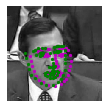

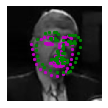

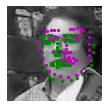

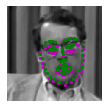

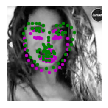

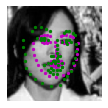

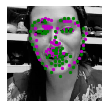

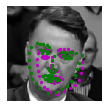

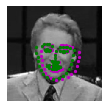

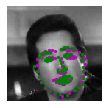

tensor([[[-0.9147,  0.3527],
         [-0.8785,  0.5961],
         [-0.8301,  0.8239],
         ...,
         [ 0.3439,  1.1907],
         [ 0.2633,  1.2019],
         [ 0.1543,  1.1977]],

        [[-0.9002, -0.2389],
         [-0.8586,  0.0221],
         [-0.8074,  0.2558],
         ...,
         [ 0.5174,  0.6948],
         [ 0.4277,  0.7104],
         [ 0.3227,  0.7031]],

        [[-0.5389, -0.3756],
         [-0.4811, -0.0513],
         [-0.4023,  0.2301],
         ...,
         [ 0.9418,  0.6179],
         [ 0.8204,  0.6397],
         [ 0.6817,  0.6410]],

        ...,

        [[-0.6062,  0.5007],
         [-0.6014,  0.7785],
         [-0.5468,  1.0401],
         ...,
         [ 0.3016,  1.4588],
         [ 0.1919,  1.4710],
         [ 0.1115,  1.4647]],

        [[-0.3970,  0.1015],
         [-0.4012,  0.3345],
         [-0.3810,  0.5497],
         ...,
         [ 0.3553,  0.9526],
         [ 0.2651,  0.9580],
         [ 0.1812,  0.9435]],

        [[-0.6148,  0.4689],
       

In [22]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:
visualize_output(test_images, test_outputs, gt_pts)
print(test_outputs)

Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [23]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'landmark_model_300W.pt'

# after training, save your model parameters in the dir 'saved_models'
# torch.save(net.state_dict(), model_dir+model_name)
torch.save(net.state_dict(), "landmark_default_dataset.pt")



After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: Optimisation functions calculate the gradient so to calculate the partial derivative of loss function with respect to weights, and the weights are modified in the opposite direction of the calculated gradient, I used SGD optimisation function. After rigourous tests, the results showed that it is much faster and yields low loss as compared to the other optimization functions that I implemented.This function furthur got improved by tuning important parametes like momentum, learning rate etc.The implementation of SGD with Momentum subtly differs from other implementations in some other frameworks.

Loss functions calculate difference between output and target variable, I used MSELoss(). It creates a criterion that measures the mean squared error (squared L2 norm) between each element in the input x and target y. As opposed to the other loss functions implemented by me, like CrossEntropyLoss() which combines nn.LogSoftmax() and nn.NLLLoss() in one single class, MSELoss() calculates the mean(L),sum(L) whenever size_average=True or false respectively. Here I've applied size_average=True where the sum operation still operates over all the elements, but divides all by n.
	  
 

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I began with a simple two layer convolution layer network eack followed by a max pooling layer and finally flattening it with a Flatten layer.

After trying the above mentioned architecture the loss was still too much as the image dimension being fed into the last layer was still was huge number and this needed to be scaled down into singular numbers. On realising this and seeing constant loss of the model I finally increasing the layers one by one till my loss eventually started decreasing.

My final model was-


      (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
      (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=18432, out_features=1024, bias=True)
      (fc1_drop): Dropout(p=0.5)
      (fc2): Linear(in_features=1024, out_features=136, bias=True)

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: This was simply a result of observation of the loss values after each step.
Started with epoch equals one and batch size 20 i started training the network. The loss seemed to be decreasing and so i decided to increase the epoch to 5 and batch size to 10 which made the loss even less.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.10691436 -0.00988385 -0.03120955 -0.00961811  0.07264147]
 [-0.18490097 -0.10237479  0.08992515  0.08591953 -0.11768848]
 [ 0.10198689 -0.05663591  0.10424545 -0.17107572 -0.06736431]
 [ 0.05036532 -0.25375056 -0.11053912 -0.11199309  0.03962721]
 [ 0.06526154 -0.08076985  0.03049143 -0.06246084 -0.04442466]]
(5, 5)


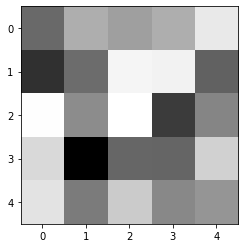

In [19]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.detach().cpu().clone().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [20]:
##TODO: load in and display any image from the transformed test dataset
import cv2
image = cv2.imread('./images/obamas.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.title("Orginal Image")

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
filtered = cv2.filter2D(image, -1, w[filter_index][0])
#filtered_image = cv2.filter2D(image, -1, CUSTOM)
fig = plt.figure()
ax = fig.add_subplot(121, xticks = [], yticks = [])
ax.imshow(filtered)
ax.set_title("Feature Map")
ax = fig.add_subplot(122, xticks = [], yticks = [])
ax.imshow(w[filter_index][0], cmap = 'gray')

plt.show()


error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: It acts as a representation of the input.The hidden layers of the network carry out feature extraction from the image i.e. here the CNN detects the areas that have high or low content of brightness in the image. For example, on the green board behind Michelle Obama, the whole board is of similar color, the color varies as the content of brightness increases or decreases.This type of feature map helps extract those areas that are similar in the picture in terms of the level of brightness.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!